# FORT drop recapture experiment 
Preston Huft, August 2019

Methodology from code by M. Saffman, and Grainger 
 

## Setup

In [4]:
# %matplotlib notebook

## libraries
from matplotlib import pyplot as plt
import numpy as np
from numpy import linspace,empty,sin,cos,log,exp,sqrt,meshgrid,array
from numpy.random import normal
from scipy.optimize import curve_fit
from math import pi,e
from random import random as rand

## local files
import sys
sys.path.append('..\\')
sys.path.append('..\\utilities')
from physconsts import *
from rbconsts import *
from rbensemble import RbEnsemble as ensemble

In [5]:
class dipole_trap: # class now lives in amophys.py
    
    def __init__(self,wx,Tdepth,Tatom,wy=None):
        self.wx = wx
        self.Tdepth = Tdepth
        self.T = Tatom
        if wy is None:
            self.wy = wx
        
        # FORT and atom parameter stuff
        self.umax = kB*self.Tdepth # the maximum FORT depth
        self.lmbda = 1.064e-6 # the trap wavelength

        self.zR = pi*wx**2/self.lmbda
        self.omega_r = (1/sqrt((self.wx**2+self.wy**2)/2))*sqrt(2*kB*self.Tdepth/mRb) # radial trap frequency 
        self.omega_z = (1/self.zR)*sqrt(2*kB*self.Tdepth/mRb) # axial trap frequency
        print(f"omega_r = {self.omega_r*1e-3:.3f} kHz, omega_z = {self.omega_z*1e-3:.3f} kHz")

    def U(self,x,y,z):
        """ the potential energy as a function of space in the dipole trap """
        zR = self.zR
        wx = self.wx
        wy = self.wy
        ww = (1+z**2/zR**2) 
        umax = self.umax
        return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww 
    
    def xdist(self,events,plane=None):
        """ position component distributions """
        # Grainger group method
        omega_r = self.omega_r
        omega_z = self.omega_z
        T = self.T
        dx = dy = sqrt(kB*T/(mRb*omega_r**2))
        dz = sqrt(kB*T/(mRb*omega_z**2))
        zlist = normal(0,dz,size=events)
        xlist = normal(0,dx,size=events)
        ylist = normal(0,dy,size=events)
        
        if plane is 'xz':
            return xlist,zlist
        else:
            return xlist,ylist,zlist
    
    def vdist(self,events):
        """ maxwell boltzmann speeds """
        umax = self.umax
        atoms = ensemble(self.T)
        
        vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds

        vxlist = empty(events)
        vylist = empty(events)
        vzlist = empty(events)
        
        for i in range(events):
            ex = 2*rand()-1
            ey = 2*rand()-1
            ez = 2*rand()-1
            v = vlist[i]
            A = sqrt(ex**2+ey**2+ez**2)
            vxlist[i] = ex*v/A
            vylist[i] = ey*v/A
            vzlist[i] = ez*v/A
            
#         vlist = array([sqrt(vx**2+vy**2+vx**2) for vx,vy,vz in zip(vxlist,vylist,vzlist)])
#         plt.hist(vlist, 50, density=True) # show maxwell boltzmann speed dist
#         plt.xlabel('v')
#         plt.ylabel('occurences')
#         plt.show()

        return vxlist,vylist,vzlist
    
    def distplot(self,events, atoms=True, sx=1.5, sz=1.5, color="bone"):
        """ show atoms in FORT in z = 0 plane before drop and recapture """
        mu = 1e-6
        wx = self.wx
        zR = self.zR
        print(f"zr={zR/mu:.0f} [um], wx={wx/mu:.0f} [um]")
        
        xlist,ylist = self.xdist(events,plane='xz') # positions in [m]
        
        xpts = linspace(-sx*wx,sx*wx,100)
        zpts = linspace(-sz*zR,sz*zR,100)
        xx,zz = meshgrid(xpts,zpts)
        fpts = -self.U(xx,0,zz) # the fort intensity eval'd on the meshgrid
        
        cmap = plt.cm.get_cmap(color)
        
        plt.contourf(xpts/mu,zpts/mu,fpts, cmap=cmap)
        if atoms is True: # otherwise, just a dipole trap plot  
            plt.scatter(xlist/mu,ylist/mu,color='red')
        plt.xlabel("x")
        plt.ylabel("z")
#         plt.axes().set_aspect('equal')
        plt.show() 

    def drop_recap(self,tlist,T=None,events=None,base_retention=None,
            progress=False):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment. 
        
            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT 
        """
      
        Tdepth = self.Tdepth
        wx = self.wx
        umax = self.umax
        zR = self.zR
        tlist = 1e-6*tlist

        if T is None:
            T = self.T
        if events is None:
            events = 2000
        if base_retention is None:
            base_retention = 1 # the retention baseline with no fort drop

        retention = empty(len(tlist))
   
        xlist,ylist,zlist = self.xdist(events)
        vzlist,vxlist,vylist = self.vdist(events)

        for j,t in enumerate(tlist):

            escape = 0 
            nhot = 0 # this is an untrapped atom

            for i in range(events):     
                hot = 0
                KE = .5*mRb*((vxlist[i]-g*t)**2+vylist[i]**2
                              +vzlist[i]**2)
                PE0 = self.U(xlist[i],ylist[i],zlist[i])
                PE = self.U(xlist[i]+t*vxlist[i]+.5*g*(t)**2,
                       ylist[i]+t*vylist[i],
                       zlist[i]+t*vzlist[i])

                if KE + PE0 > 0:
                    hot = 1
                nhot += hot
                if KE + PE > 0:
                    escape += 1-hot
            retention[j] = base_retention*(1 - escape/events)
            
            if progress is not False:
                if j % 10 == 0:
                    print(f"timestep {j}: t = {t*1e6:.0f} [us], ret = {retention[j]:.2f}")

#         plt.plot(tlist*1e6,retention,label=f'{T/1e-6:.0f} uK') # show time in units [us]
#         plt.xlabel("time [us]")
#         plt.ylabel("retention")
#         plt.ylim((0,1))
#         plt.legend()
#         plt.show()        
        
        print(f"finished. T={T*1e6} [uK], r = {base_retention}")
        return tlist*1e6,retention
    
    def curvefit(self,tdata,rdata):
        """ For using the release_recap procedure to fit real data.
            
            tdata: time pts from data
            rdata: retention pts data
        """
        def f(tlist,T,r):
            """
                tlist: times [s]
                T: atom temp [K]
                r: baseline retention in (0,1]
            """
            
            t,y = self.drop_recap(tlist,T=T,base_retention=r)
            return y
        
        p0=[self.T,1] # scale up the temp
        popt,pcov = curve_fit(f,tdata,rdata,p0,
                              absolute_sigma=True)
        
        Topt,ropt = popt # the optimum parameters
        
        print(f"T_fit = {Topt*1e6:.0f}")
        tlist,ret=self.drop_recap(tdata,T=Topt,base_retention=ropt)
        
        plt.plot(tlist,ret,label=f"T_fit = {Topt*1e6:.0f}")
        plt.scatter(tdata,rdata,label='real live data',color='r')
        plt.show()
        
        return tlist,ret

<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\prest\AppData\Local\Temp\ipykernel_19684\162722198.py:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if plane is 'xz':


## Run release-recapture simulation

omega_r = 588.136 kHz, omega_z = 265.588 kHz
finished. T=10.0 [uK], r = 1.0
omega_r = 588.136 kHz, omega_z = 265.588 kHz
finished. T=30.0 [uK], r = 1.0
omega_r = 588.136 kHz, omega_z = 265.588 kHz
finished. T=50.0 [uK], r = 1.0
omega_r = 588.136 kHz, omega_z = 265.588 kHz
finished. T=100.0 [uK], r = 1.0


Text(0, 0.5, 'retention')

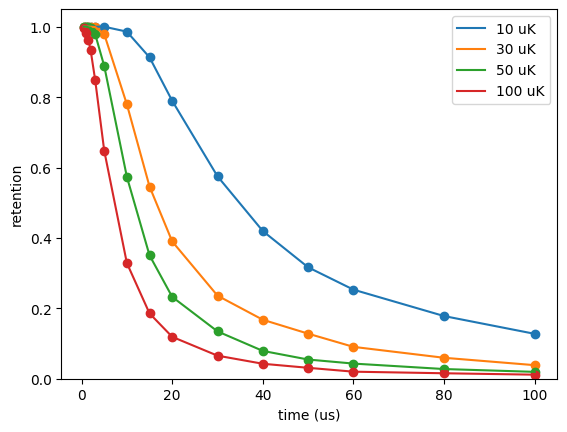

In [26]:
# a test with 30 uK atoms
w0 = 0.75e-6 # [m]
TFORT = 1e-3 # [K]
tlist = np.array([0.5, 1, 1.5, 2, 3, 5, 10, 15, 20, 30, 40, 50, 60, 80, 100])  # time [us]
# tlist = linspace(0,100,20) # time [us]
for Tatom in [1e-5, 3e-5, 5e-5, 1e-4]:
    tempexp = dipole_trap(w0,TFORT,Tatom)
    tlist,reten = tempexp.drop_recap(tlist,base_retention=1.00)
    plt.plot(tlist, reten, label=f"{Tatom*1e6:.0f} uK")
    plt.scatter(tlist, reten) #, label=f"{Tatom*1e6:.0f} uK")
plt.legend()
plt.ylim((0,1.05))
plt.xlabel("time (us)")
plt.ylabel("retention")

In [11]:
sqrt(kB*tempexp.T/(mRb*tempexp.omega_r**2))

3.227486121839515e-07

In [12]:
tempexp = dipole_trap(w0,TFORT,Tatom)
# tempexp.distplot(100) # example of atoms in xz plane of FORT at t=0
tlist,reten = tempexp.drop_recap(tlist,base_retention=.95)
plt.plot(tlist,reten,label=f'{tempexp.T/1e-6:.0f} uK') # show time in units [us]

omega_r = 216.095 kHz, omega_z = 29.275 kHz
finished. T=50.0 [uK], r = 0.95


zr=18 [um], wx=3 [um]


C:\Users\prest\AppData\Local\Temp\ipykernel_19684\162722198.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color)


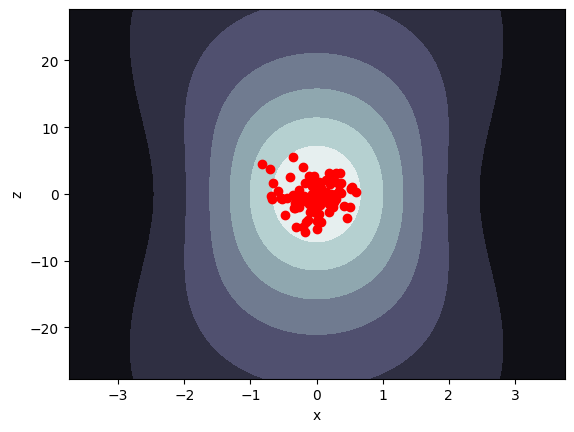

In [13]:
tempexp.distplot(100) # example of atoms in xz plane of FORT at t=0

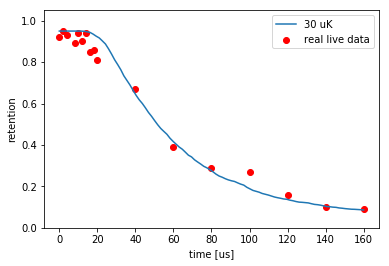

In [4]:
t_data = array([0.0, 2.0, 4.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 
                20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0])
ret_data = [0.92079207920792083, 0.94999999999999996, 0.93000000000000005, 
            0.89000000000000001, 0.93999999999999995, 0.90000000000000002, 
            0.93999999999999995, 0.84999999999999998, 0.85999999999999999, 
            0.81000000000000005, 0.67000000000000004, 0.39000000000000001, 
            0.28712871287128711, 0.27000000000000002, 0.16, 0.10000000000000001, 
            0.089999999999999997]

plt.scatter(t_data,ret_data,label='real live data',color='r')
plt.plot(tlist,reten,label=f'{tempexp.T/1e-6:.0f} uK') # show time in units [us]
plt.xlabel("time [us]")
plt.ylabel("retention")
plt.ylim((0,1.05))
plt.legend()
plt.show()

## Fit real data

omega_r = 216.095 kHz, omega_z = 29.275 kHz
finished. T=30.0 [uK], r = 1.0
finished. T=30.0 [uK], r = 1.0
finished. T=30.0 [uK], r = 1.0
finished. T=30.000000447034836 [uK], r = 1.0
finished. T=30.0 [uK], r = 1.0000000149011612
finished. T=30.000000263517236 [uK], r = 1.0000000679269274
finished. T=30.000000710552076 [uK], r = 1.0000000679269274
finished. T=30.000000263517236 [uK], r = 1.0000000828280897
finished. T=29.99999961657306 [uK], r = 1.0000000728400462
finished. T=29.99999961657306 [uK], r = 1.0000000728400462
T_fit = 30
finished. T=29.99999961657306 [uK], r = 1.0000000728400462


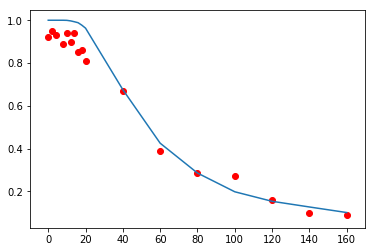

In [6]:
# try to fit the datas 
t_data = array([0.0, 2.0, 4.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 
                20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0])
ret_data = [0.92079207920792083, 0.94999999999999996, 0.93000000000000005, 
            0.89000000000000001, 0.93999999999999995, 0.90000000000000002, 
            0.93999999999999995, 0.84999999999999998, 0.85999999999999999, 
            0.81000000000000005, 0.67000000000000004, 0.39000000000000001, 
            0.28712871287128711, 0.27000000000000002, 0.16, 0.10000000000000001, 
            0.089999999999999997]

w0 = 2.5e-6 # [m]
TFORT = 1.5e-3 # [K]
Tatom = 3e-5 # [K] # this will be a fit guess
steps = 100
tempexp = dipole_trap(w0,TFORT,Tatom)
tlist,reten = tempexp.curvefit(t_data,ret_data)

In [47]:
# FORT plot
w0 = 2.5e-6 # [m]
TFORT = 1.5e-3 # [K]
tempexp = dipole_trap(w0,TFORT,Tatom)
tempexp.lmbda = 7.8e-7

omega_r = 216.095 kHz, omega_z = 29.275 kHz


zr=18 [um], wx=3 [um]


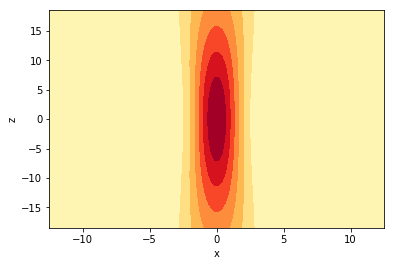

In [48]:
tempexp.distplot(0, sx=5, sz=1, color="YlOrRd")

In [12]:
help(tempexp.distplot)

Help on method distplot in module __main__:

distplot(events, atoms=True) method of __main__.dipole_trap instance
    show atoms in FORT in z = 0 plane before drop and recapture

